# Проект: Предсказание риска сердечного приступа

## Общая информация и цель проекта

В этом проекте предполагается работа с датасетом из открытого источника. Потребуется разработать модель машинного обучения, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке. В начале проекта доступен обучающий датасет и тестовый датасет, не содержащий правильных ответов. Метрика на тестовом датасете будет измерена в ходе проверки работы. Также  доступен скрипт, с помощью которого будет измеряться финальная метрика модели.

## Описание данных

В предоставленном датасете содержится медицинская информация о пациентах:
* id - уникальный идентификатор записи;
* Антропометрические параметры (вес, возраст, рост)
* Привычки (курение, качество сна и т.д)
* Давление
* Наличие хронических заболеваний
* Биохимия крови
* Таргет - высокий или низкий риск поражения сердца

In [ ]:
# --- Базовые ---
import warnings
from pprint import pprint
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.api.types import is_bool_dtype, is_numeric_dtype

# --- Визуализация ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Отображение в Jupyter ---
from IPython.display import display, Markdown

# --- Phik корреляции ---
import phik
from phik import resources

# --- Scikit-learn ---
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# --- ML-библиотеки ---
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# --- Прочее ---
import shap
import joblib

# --- Настройки ---
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
TEST_SIZE = 0.2
sns.set_theme()

# --- Установка пакета phik (если не установлен) ---
!pip install -U phik -q

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    RocCurveDisplay, PrecisionRecallDisplay, ConfusionMatrixDisplay
)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import shap, joblib, warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
TEST_SIZE = 0.2
sns.set_theme()

## 1. Загрузка данных

In [3]:
# Просмотр таблицы
def describe_df(df: pd.DataFrame) -> None:
    display(Markdown("### Информация о датасете:"))
    df.info()
    display(Markdown("### Пример данных:"))
    display(df.sample(10))
    display(Markdown("### Уникальные значения по столбцам:"))
    display(df.nunique())

In [4]:
def load(filename: str, fallback: str = None, **kwargs) -> pd.DataFrame:
    try:
        df = pd.read_csv(filename, **kwargs)
    except FileNotFoundError:
        if fallback:
            df = pd.read_csv(fallback, **kwargs)
        else:
            raise FileNotFoundError(f"Не удалось загрузить файл: {filename}")
    return df

In [5]:
heart_train = load("heart_train.csv", "/datasets/heart_train.csv", index_col=0)
heart_test = load("heart_test.csv", "/datasets/heart_test.csv", index_col=0)

In [6]:
# Выведем информацию о данных heart_tes
describe_df(heart_train)

### Информация о датасете:

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level             

### Пример данных:

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
6515,0.146067,0.007143,0.069661,0.0,0.0,1.0,1.0,1.0,0.506270,1,...,5.0,0.666667,0.0,0.227018,0.048229,0.036512,Male,0.316129,0.267442,7373
5813,0.292135,0.964286,0.074244,1.0,0.0,0.0,0.0,1.0,0.663108,2,...,7.0,0.666667,1.0,0.227018,0.048229,0.036512,Female,0.251613,0.639535,8751
3150,0.528090,0.471429,0.039413,1.0,0.0,1.0,0.0,0.0,0.512877,2,...,4.0,0.500000,0.0,0.312253,0.015180,0.004369,Male,0.729032,0.744186,4924
4431,0.674157,0.500000,0.046746,0.0,1.0,1.0,1.0,0.0,0.389135,0,...,6.0,0.333333,1.0,0.227018,0.048229,0.036512,Male,0.696774,0.360465,3222
6928,0.393258,0.835714,0.059578,1.0,0.0,1.0,1.0,0.0,0.812970,1,...,1.0,0.166667,0.0,0.000000,0.017882,0.004758,Male,0.722581,0.325581,5773
2496,0.460674,0.728571,0.043080,1.0,0.0,1.0,1.0,1.0,0.351258,1,...,4.0,1.000000,0.0,0.308300,0.001208,0.290222,Female,0.200000,0.697674,5937
6317,0.393258,0.082143,0.070577,1.0,1.0,1.0,1.0,0.0,0.778795,0,...,6.0,0.000000,1.0,0.227018,0.048229,0.036512,Male,0.600000,0.534884,7601
782,0.134831,0.857143,0.072411,0.0,1.0,1.0,0.0,1.0,0.869352,0,...,5.0,0.166667,0.0,0.227018,0.048229,0.036512,Male,0.374194,0.476744,8600
944,0.775281,0.610714,0.034830,1.0,1.0,1.0,0.0,1.0,0.742801,1,...,6.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.567742,0.593023,2464
3602,0.528090,0.850000,0.026581,1.0,1.0,1.0,1.0,1.0,0.747432,1,...,0.0,0.833333,0.0,0.227018,0.048229,0.036512,Female,0.670968,0.220930,4645


### Уникальные значения по столбцам:

Age                                  77
Cholesterol                         282
Heart rate                           87
Diabetes                              2
Family History                        2
Smoking                               2
Obesity                               2
Alcohol Consumption                   2
Exercise Hours Per Week            7933
Diet                                  4
Previous Heart Problems               2
Medication Use                        2
Stress Level                         10
Sedentary Hours Per Day            7933
Income                             7808
BMI                                7933
Triglycerides                       772
Physical Activity Days Per Week       8
Sleep Hours Per Day                   8
Heart Attack Risk (Binary)            2
Blood sugar                         239
CK-MB                               679
Troponin                            340
Gender                                4
Systolic blood pressure             100


Таблица с тренировочной выборкой состоит из 8685 строк и 27 столбцов.  
Имеются пропуски в 9 столбцах.  
Данные в большинстве числовых признаков (например: Age, Cholesterol, Heart rate) выглядят масштабированными в диапазон `[0, 1]`.  
Столбцы Diabetes, Family History, Smoking, Obesity, Alcohol Consumption, Previous Heart Problems, Medication Use, Stress Level, Physical Activity Days Per Week хранят категориальные данные, но имеют тип float — требуется приведение к целочисленному типу.  
Названия столбцов рекомендуется привести к формату `snake_case`.

In [7]:
describe_df(heart_test)

### Информация о датасете:

<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              966 non-null    float64
 1   Cholesterol                      966 non-null    float64
 2   Heart rate                       966 non-null    float64
 3   Diabetes                         935 non-null    float64
 4   Family History                   935 non-null    float64
 5   Smoking                          935 non-null    float64
 6   Obesity                          935 non-null    float64
 7   Alcohol Consumption              935 non-null    float64
 8   Exercise Hours Per Week          966 non-null    float64
 9   Diet                             966 non-null    int64  
 10  Previous Heart Problems          935 non-null    float64
 11  Medication Use                   935 non-null    float64
 12  Stress Level               

### Пример данных:

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
296,0.764045,0.364286,0.032081,0.0,0.0,1.0,1.0,0.0,0.672653,2,...,0.763636,7.0,0.500000,0.227018,0.048229,0.036512,Female,0.561290,0.209302,6781
416,0.764045,0.860714,0.024748,1.0,0.0,1.0,0.0,0.0,0.798675,1,...,0.837662,5.0,0.666667,0.227018,0.048229,0.036512,Female,0.225806,0.709302,4031
49,0.404494,0.260714,0.048579,0.0,1.0,1.0,1.0,1.0,0.110760,2,...,0.006494,6.0,0.666667,0.594862,0.020152,0.000388,Male,0.600000,0.523256,563
620,0.842697,0.078571,0.056829,1.0,1.0,1.0,1.0,0.0,0.296144,2,...,0.923377,3.0,0.333333,0.227018,0.048229,0.036512,Male,0.438710,0.651163,2328
137,0.235955,0.428571,0.037580,1.0,0.0,1.0,0.0,1.0,0.533404,1,...,0.688312,7.0,0.500000,0.128458,0.024490,0.000194,Male,0.535484,0.325581,5378
435,0.359551,0.821429,0.047663,1.0,0.0,1.0,1.0,0.0,0.366744,1,...,0.464935,5.0,1.000000,0.227018,0.048229,0.036512,Male,0.425806,0.709302,6856
889,0.808989,0.175000,0.041247,1.0,0.0,1.0,1.0,1.0,0.800511,0,...,0.296104,0.0,0.833333,0.227018,0.048229,0.036512,Male,0.187097,0.779070,8454
74,0.112360,0.707143,0.018332,1.0,1.0,1.0,1.0,0.0,0.228398,2,...,0.763636,0.0,0.333333,0.227018,0.048229,0.036512,Male,0.593548,0.406977,3094
245,0.696629,0.575000,0.037580,0.0,1.0,1.0,0.0,0.0,0.575505,2,...,0.848052,1.0,0.166667,0.227018,0.048229,0.036512,Male,0.664516,0.395349,8253
448,0.213483,0.535714,0.058662,1.0,0.0,0.0,0.0,1.0,0.265024,2,...,0.797403,1.0,0.666667,0.227018,0.048229,0.036512,Female,0.535484,0.511628,4417


### Уникальные значения по столбцам:

Age                                 73
Cholesterol                        266
Heart rate                          76
Diabetes                             2
Family History                       2
Smoking                              2
Obesity                              2
Alcohol Consumption                  2
Exercise Hours Per Week            924
Diet                                 4
Previous Heart Problems              2
Medication Use                       2
Stress Level                        10
Sedentary Hours Per Day            924
Income                             921
BMI                                924
Triglycerides                      529
Physical Activity Days Per Week      8
Sleep Hours Per Day                  8
Blood sugar                        124
CK-MB                              183
Troponin                            96
Gender                               4
Systolic blood pressure             93
Diastolic blood pressure            54
id                       

Таблица с тестовой выборкой состоит из 966 строк и 26 столбцов.  
Имеются пропуски в 9 столбцах.  
Большинство числовых признаков (например: Age, Cholesterol, Heart rate) масштабированы в диапазон `[0, 1]`.  
Столбцы Diabetes, Family History, Smoking, Obesity, Alcohol Consumption, Previous Heart Problems, Medication Use, Stress Level, Physical Activity Days Per Week содержат категориальные данные, но имеют тип float — требуется приведение к целочисленному типу.  
Названия столбцов рекомендуется привести к формату `snake_case`.

## 2. Предобработка данных

**Предобработка тренировочной выборки**

Приведем названия столбцов к  формату `snake_case`.

In [8]:
def clean_column_names(df, show=False):
    df.columns = (
        df.columns
        .str.strip()
        .str.replace(' ', '_')
        .str.replace('-', '_')
        .str.lower()
        .str.replace(r'[()]', '', regex=True)
        .str.replace('__', '_')
    )
    if show:
        display(df.head())
    return df

In [9]:
heart_train = clean_column_names(heart_train, show=True)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,1,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,2,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,2,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,0,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,1,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047


Заменим 1.0', '0.0' на Male и Female

In [10]:
heart_train['gender'].unique()

array(['Male', 'Female', '1.0', '0.0'], dtype=object)

In [11]:
heart_train['gender'] = heart_train['gender'].astype(str)
heart_train['gender'] = heart_train['gender'].replace({
    '1.0': 'Male',
    '0.0': 'Female'
})

Проверим дубликаты

In [12]:
def check_duplicates(df, id_col='id'):
    full_dups = df[df.duplicated()]
    id_dups = df[df[id_col].duplicated(keep=False)] if id_col in df else None
    print(f"Полные дубликаты: {len(full_dups)}")
    print(f"Дубликаты по '{id_col}': {len(id_dups) if id_dups is not None else '—'}")
    return full_dups, id_dups

In [13]:
full_dups, id_dups = check_duplicates(heart_train)

Полные дубликаты: 0
Дубликаты по 'id': 0


Посмотрим на пропуски.

In [14]:
def show_missing_rows(df):
    cols_with_na = df.columns[df.isnull().any()].tolist()
    print(f"Колонки с пропусками: {cols_with_na}")

    missing_rows = df[df[cols_with_na].isnull().any(axis=1)]
    n_missing = missing_rows.shape[0]
    pct_missing = n_missing / len(df) * 100
    print(f" Найдено строк с пропусками: {n_missing} ({pct_missing:.2f}% от всего датасета)")

    display(missing_rows)
    return missing_rows

In [15]:
missing_rows = show_missing_rows(heart_train)

Колонки с пропусками: ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems', 'medication_use', 'stress_level', 'physical_activity_days_per_week']
 Найдено строк с пропусками: 243 (2.80% от всего датасета)


,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
16,0.449438,0.49978,0.063245,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,NaN,0.504621,0.0,0.233202,0.026692,0.000777,Male,0.393548,0.255814,9528
90,0.370787,0.49978,0.066911,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,NaN,0.504621,0.0,0.154150,0.004702,0.042043,Male,0.258065,0.337209,9640
92,0.629213,0.49978,0.073327,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,NaN,0.504621,0.0,0.256917,0.012310,0.000777,Female,0.258065,0.232558,9515
185,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,NaN,0.504621,0.0,0.559289,0.006704,0.000291,Female,0.174194,0.151163,9491
188,0.269663,0.49978,0.035747,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,NaN,0.504621,0.0,0.112648,0.051218,0.000485,Female,0.225806,0.162791,9448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8461,0.719101,0.49978,0.049496,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,NaN,0.504621,0.0,0.138340,0.004034,0.003204,Male,0.548387,0.558140,9455
8509,0.651685,0.49978,0.036664,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,NaN,0.504621,0.0,0.239130,0.055790,0.060783,Male,0.729032,0.779070,9506
8536,0.651685,0.49978,0.054079,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,NaN,0.504621,0.0,0.276680,0.008673,0.150403,Male,0.606452,0.790698,9474
8619,0.606742,0.49978,0.059578,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,NaN,0.504621,0.0,0.156126,0.057692,0.000583,Female,0.387097,0.500000,9467


Заполним пропуски

In [ ]:
binary_cols = [
    "diabetes", "family_history", "smoking", "obesity",
    "previous_heart_problems", "medication_use"
]

for col in binary_cols:
    if col in heart_train.columns:
        mode_val = heart_train[col].mode()[0]
        heart_train[col] = heart_train[col].fillna(mode_val)


for col in ["alcohol_consumption", "stress_level"]:
    if col in heart_train.columns:
        median_val = heart_train[col].median()
        heart_train[col] = heart_train[col].fillna(median_val)


col = "physical_activity_days_per_week"
if col in heart_train.columns:
    mode_val = heart_train[col].mode()[0]
    heart_train[col] = heart_train[col].fillna(mode_val)


print("Оставшиеся пропуски в train:\n", heart_train.isnull().sum()[lambda x: x > 0])

Оставшиеся пропуски в train:
 Series([], dtype: int64)


Пропусков больше нет

Категориальные признакими  приведем к типу данных string.

In [17]:
cat_features = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption',
               'diet', 'previous_heart_problems', 'medication_use', 'heart_attack_risk_binary', 'gender']

In [18]:
for feature in cat_features:
    heart_train[feature] = heart_train[feature].astype('string')

In [19]:
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8685 non-null   float64
 1   cholesterol                      8685 non-null   float64
 2   heart_rate                       8685 non-null   float64
 3   diabetes                         8685 non-null   string 
 4   family_history                   8685 non-null   string 
 5   smoking                          8685 non-null   string 
 6   obesity                          8685 non-null   string 
 7   alcohol_consumption              8685 non-null   string 
 8   exercise_hours_per_week          8685 non-null   float64
 9   diet                             8685 non-null   string 
 10  previous_heart_problems          8685 non-null   string 
 11  medication_use                   8685 non-null   string 
 12  stress_level             

In [20]:
for feature in cat_features:
    print(f'Уникальные значения в столбце "{feature}":\n{heart_train[feature].unique()}\n')

Уникальные значения в столбце "diabetes":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "family_history":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "smoking":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "obesity":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "alcohol_consumption":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "diet":
<StringArray>
['1', '2', '0', '3']
Length: 4, dtype: string

Уникальные значения в столбце "previous_heart_problems":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "medication_use":
<StringArray>
['0.0', '1.0']
Length: 2, dtype: string

Уникальные значения в столбце "heart_attack_risk_binary":
<StringArray>
['0.0', '1.0']
Length: 2, dtype: string

Уникальные значения в столбце "gender":
<StringArray>
['Male', 'Female']


**Предобработка тестовой выборкой**

In [21]:
heart_test = clean_column_names(heart_test, show=True)

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,2,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,2,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,0,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,0,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,0,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825


In [22]:
heart_test['gender'].unique()

array(['Male', 'Female', '1.0', '0.0'], dtype=object)

In [23]:
heart_test['gender'] = heart_train['gender'].astype(str)
heart_test['gender'] = heart_train['gender'].replace({
    '1.0': 'Male',
    '0.0': 'Female'
})

Проверим дубликаты

In [24]:
full_dups, id_dups = check_duplicates(heart_test)

Полные дубликаты: 0
Дубликаты по 'id': 0


Посмотрим на пропуски.

In [25]:
missing_rows = show_missing_rows(heart_test)

Колонки с пропусками: ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems', 'medication_use', 'stress_level', 'physical_activity_days_per_week']
 Найдено строк с пропусками: 31 (3.21% от всего датасета)


,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure,id
27,0.370787,0.49978,0.034830,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.181818,0.011843,0.000194,Male,0.419355,0.441860,9613
37,0.573034,0.49978,0.043080,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.167984,0.011209,0.000971,Female,0.722581,0.732558,9471
58,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.098814,0.036436,0.002233,Male,0.387097,0.500000,9486
60,0.370787,0.49978,0.056829,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.199605,0.005970,0.006408,Male,0.387097,0.220930,9391
61,0.483146,0.49978,0.028414,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.112648,0.013111,0.000680,Male,0.419355,0.325581,9579
156,0.516854,0.49978,0.045830,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.219368,1.000000,0.000583,Female,0.335484,0.220930,9490
208,0.449438,0.49978,0.036664,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.264822,0.008906,0.002136,Male,0.380645,0.186047,9617
235,0.325843,0.49978,0.029331,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.128458,0.002196,0.000583,Male,0.387097,0.302326,9465
265,0.471910,0.49978,0.056829,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.083004,0.020218,0.000485,Male,0.096774,0.441860,9562
339,0.348315,0.49978,0.054079,NaN,NaN,NaN,NaN,NaN,0.50211,3,...,0.503603,NaN,0.504621,0.207510,0.006137,0.000388,Male,0.174194,0.151163,9412


Заполним пропуски

In [ ]:
binary_cols = [
    "diabetes", "family_history", "smoking", "obesity",
    "previous_heart_problems", "medication_use"
]

for col in binary_cols:
    if col in heart_test.columns:
        mode_val = heart_test[col].mode()[0]
        heart_test[col] = heart_test[col].fillna(mode_val)

for col in ["alcohol_consumption", "stress_level"]:
    if col in heart_test.columns:
        # Преобразуем в float, если нужно
        heart_test[col] = pd.to_numeric(heart_test[col], errors='coerce')
        median_val = heart_test[col].median()
        heart_test[col] = heart_test[col].fillna(median_val)

# physical_activity_days_per_week — мода
col = "physical_activity_days_per_week"
if col in heart_test.columns:
    mode_val = heart_test[col].mode()[0]
    heart_test[col] = heart_test[col].fillna(mode_val)


print("Оставшиеся пропуски в test:\n", heart_test.isnull().sum()[lambda x: x > 0])

Оставшиеся пропуски в test:
 Series([], dtype: int64)


Категориальные признакими  приведем к типу данных string.

In [27]:
cat_features = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption',
               'diet', 'previous_heart_problems', 'medication_use', 'gender']

In [28]:
for feature in cat_features:
    heart_test[feature] = heart_test[feature].astype('string')

In [29]:
for feature in cat_features:
    print(f'Уникальные значения в столбце "{feature}":\n{heart_test[feature].unique()}\n')

Уникальные значения в столбце "diabetes":
<StringArray>
['0.0', '1.0']
Length: 2, dtype: string

Уникальные значения в столбце "family_history":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "smoking":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "obesity":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "alcohol_consumption":
<StringArray>
['1.0', '0.0']
Length: 2, dtype: string

Уникальные значения в столбце "diet":
<StringArray>
['2', '0', '1', '3']
Length: 4, dtype: string

Уникальные значения в столбце "previous_heart_problems":
<StringArray>
['0.0', '1.0']
Length: 2, dtype: string

Уникальные значения в столбце "medication_use":
<StringArray>
['0.0', '1.0']
Length: 2, dtype: string

Уникальные значения в столбце "gender":
<StringArray>
['Male', 'Female']
Length: 2, dtype: string



## Вывод по редобработке данных

На этапе предобработки данные были приведены к удобному формату для дальнейшего анализа и обучения моделей:

- Проверено наличие дубликатов — не обнаружено.
- Названия столбцов унифицированы в едином стиле.
- Категориальные признаки приведены к соответствующему типу данных.
- Строки с пропущенными значениями заполнены.


## 3. Исследовательский анализ данных

**Создадим вспомогательную функцию**
- `_is_categorical` — проверяет, является ли признак категориальным

In [30]:
def _is_categorical(s: pd.Series) -> bool:
    dt = s.dtype
    return (isinstance(dt, pd.CategoricalDtype) 
            or is_bool_dtype(s) 
            or dt == "object" 
            or dt == "string")

- `_has_variation(arr)` — проверяет, есть ли в массиве хотя бы два уникальных числовых значения (исключая NaN и бесконечности).  
- `_ensure_legend(ax, title, labels, palette)` — гарантированно добавляет легенду на график с нужными подписями и цветами, даже если seaborn её не создал.  
- `plot_features_overview(...)` — строит сетку графиков для признаков датафрейма:  
  - в одиночном режиме — сравнение распределений по целевому признаку (countplot для категориальных, KDE/гистограмма для числовых);  
  - в режиме сравнения — сравнение Train/Test по всем признакам с фиксированной легендой.  

In [31]:
def _has_variation(arr: np.ndarray) -> bool:
    arr = np.asarray(arr, dtype=float)
    arr = arr[np.isfinite(arr)]
    return (arr.size >= 2) and (np.unique(arr).size >= 2)

def _ensure_legend(ax, *, title: str, labels: list[str], palette):
    leg = ax.get_legend()
    if leg is not None and len(leg.get_texts()) > 0:
        leg.set_title(title)
        return
    
    colors = []
    if isinstance(palette, dict):
        for lab in labels:
            colors.append(palette.get(lab))
    else:
        base = palette if palette is not None else sns.color_palette(None, n_colors=len(labels))
        for i in range(len(labels)):
            colors.append(base[i])

    handles = [plt.Line2D([0], [0], lw=10, color=c) for c in colors]
    ax.legend(handles=handles, labels=labels, title=title)

def plot_features_overview(
    df: pd.DataFrame,
    cols=None,
    *,
    df_compare: pd.DataFrame | None = None,
    target: str | None = None,
    ncols: int = 2,
    bins: str | int = "auto",
    kde: bool = True,
    height: float = 4.0,
    palette=None,
):
    
    sns.set_theme()

    use_cols = list(cols) if cols is not None else list(df.columns)
    if target in use_cols:
        use_cols.remove(target)

    compare_mode = df_compare is not None
    if compare_mode:
        common = set(use_cols).intersection(df_compare.columns)
        use_cols = [c for c in use_cols if c in common]

    
    if compare_mode:
        base_pal = palette if palette is not None else sns.color_palette(None, n_colors=2)
        if isinstance(base_pal, dict):
            comp_palette = {
                "Train": base_pal.get("Train", sns.color_palette(None, 2)[0]),
                "Test":  base_pal.get("Test",  sns.color_palette(None, 2)[1]),
            }
        else:
            comp_palette = {"Train": base_pal[0], "Test": base_pal[1]}
        hue_order_cmp = ["Train", "Test"]

    n = len(use_cols)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * height), squeeze=False)
    axes = axes.ravel()

    for i, col in enumerate(use_cols):
        ax = axes[i]
        is_cat = _is_categorical(df[col])

        
        if compare_mode:
            a = df[[col]].copy();         a["source"] = "Train"
            b = df_compare[[col]].copy(); b["source"] = "Test"
            combo = pd.concat([a, b], ignore_index=True)

            if is_cat:
                sns.countplot(
                    data=combo, x=col, hue="source", hue_order=hue_order_cmp,
                    ax=ax, palette=comp_palette
                )
                ax.set_ylabel("Количество")
                ax.tick_params(axis="x", rotation=30)
                ax.set_title(f"{col} — Категориальный признак")
                _ensure_legend(ax, title="source", labels=hue_order_cmp, palette=comp_palette)
            else:
                if kde:
                    try:
                        sns.kdeplot(
                            data=combo, x=col, hue="source", hue_order=hue_order_cmp,
                            ax=ax, fill=True, multiple="stack", common_norm=False,
                            warn_singular=False, palette=comp_palette
                        )
                        ax.set_ylabel("Плотность")
                    except Exception:
                        sns.histplot(
                            data=combo, x=col, hue="source", hue_order=hue_order_cmp,
                            ax=ax, bins=bins, stat="density", multiple="layer",
                            palette=comp_palette
                        )
                        ax.set_ylabel("Плотность")
                else:
                    sns.histplot(
                        data=combo, x=col, hue="source", hue_order=hue_order_cmp,
                        ax=ax, bins=bins, stat="density", multiple="layer",
                        palette=comp_palette
                    )
                    ax.set_ylabel("Плотность")

                ax.set_xlabel(col)
                ax.set_title(f"{col} — Числовой признак")
                _ensure_legend(ax, title="source", labels=hue_order_cmp, palette=comp_palette)
            continue

        
        if is_cat:
            sns.countplot(x=col, data=df, hue=target, ax=ax, palette=palette)
            ax.set_ylabel("Количество")
            ax.tick_params(axis="x", rotation=30)
            ax.set_title(f"{col} — Категориальный признак")
            if target is not None:
                leg = ax.get_legend()
                if leg is not None:
                    leg.set_title(target)
        else:
            if target and target in df.columns:
                if kde:
                    try:
                        sns.kdeplot(
                            data=df, x=col, hue=target, ax=ax,
                            fill=True, multiple="stack", common_norm=False,
                            warn_singular=False, palette=palette
                        )
                        ax.set_ylabel("Плотность")
                    except Exception:
                        sns.histplot(
                            data=df, x=col, hue=target, ax=ax,
                            bins=bins, stat="density", multiple="layer", palette=palette
                        )
                        ax.set_ylabel("Плотность")
                else:
                    sns.histplot(
                        data=df, x=col, hue=target, ax=ax,
                        bins=bins, stat="density", multiple="layer", palette=palette
                    )
                    ax.set_ylabel("Плотность")

                leg = ax.get_legend()
                if leg is not None:
                    leg.set_title(target)
            else:
                arr = df[col].dropna().to_numpy()
                if kde and _has_variation(arr):
                    sns.kdeplot(x=arr, ax=ax, warn_singular=False)
                    ax.set_ylabel("Плотность")
                else:
                    sns.histplot(x=arr, ax=ax, bins=bins, stat="count")
                    ax.set_ylabel("Количество")

            ax.set_xlabel(col)
            ax.set_title(f"{col} — Числовой признак")

    
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()
    return fig, axes[:n]



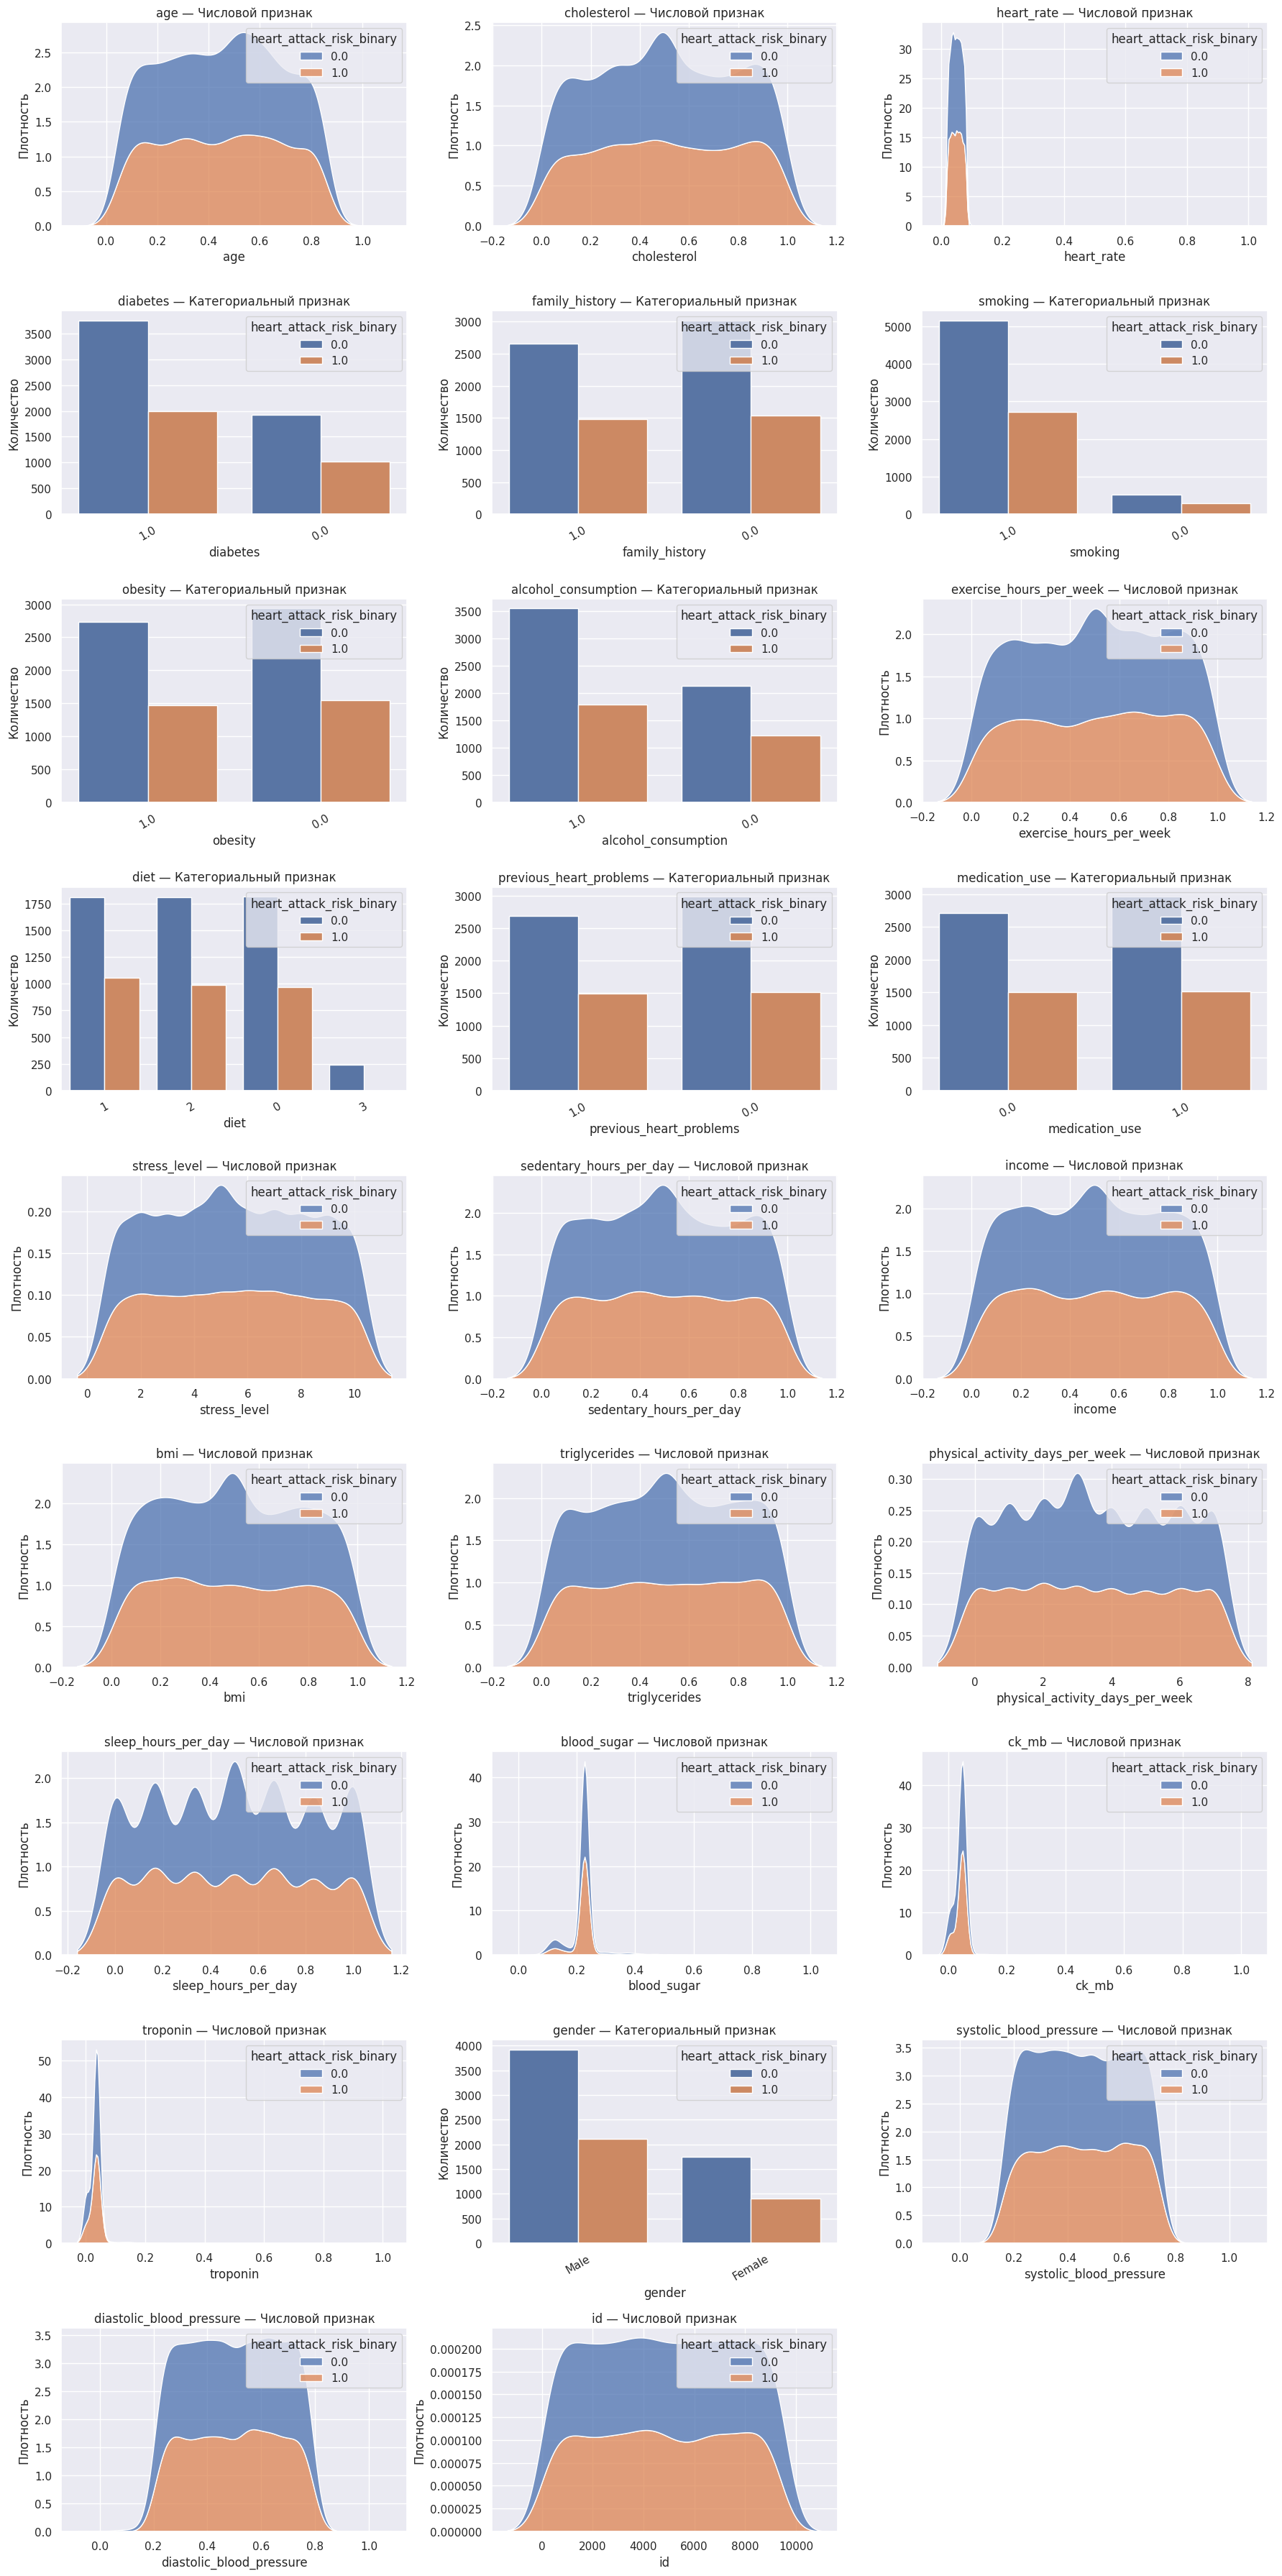

In [32]:
plot_features_overview(
    heart_train,
    target="heart_attack_risk_binary",
    ncols=3
);

Сравним распределения

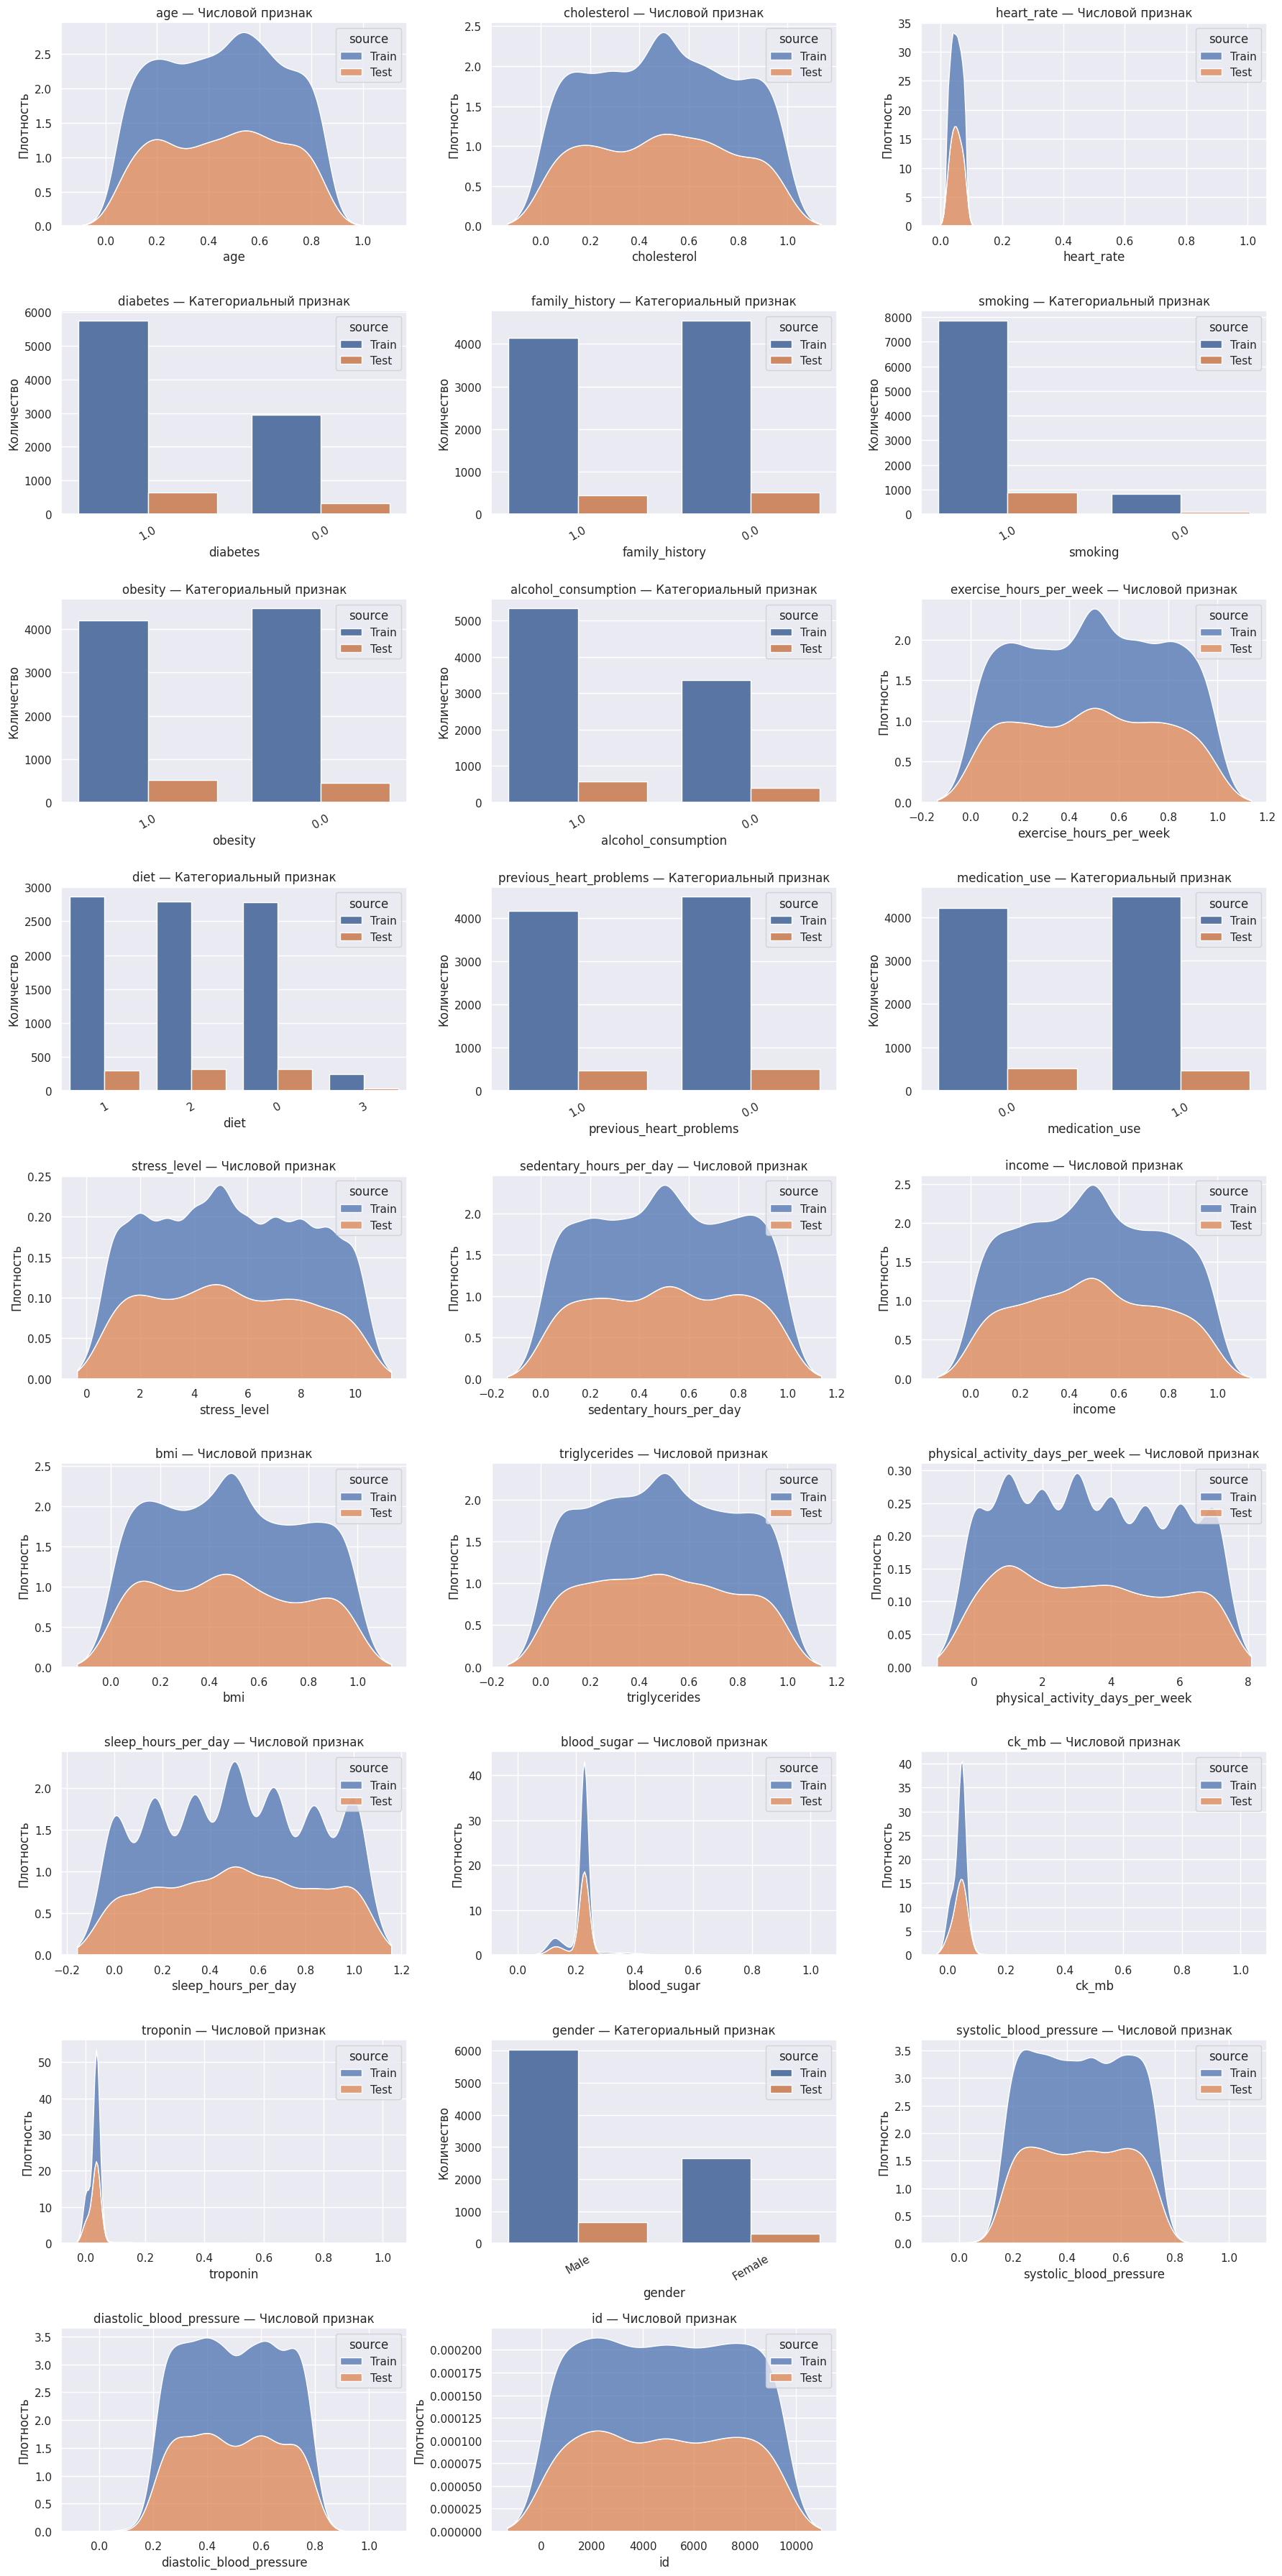

In [33]:
plot_features_overview(
    heart_train,
    df_compare=heart_test,
    ncols=3,
    kde=True
);

**Выводы по исследовательскому анализу данных**

Сравнение Train/Test: распределения признаков в тренировочной (8442 строк) и тестовой (935 строк) выборках в целом схожи с учётом разницы в объёме данных.

Количественные признаки: для 'stress_level', 'physical_activity_days_per_week', 'sleep_hours_per_day', 'age', 'cholesterol', 'heart_rate', 'exercise_hours_per_week', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', 'systolic_blood_pressure', 'diastolic_blood_pressure' распределения равномерные, значимых выбросов не наблюдается.

Выраженные моды и выбросы: в 'blood_sugar', 'ck_mb', 'troponin' присутствует ярко выраженная мода и большое количество выбросов.

Категориальные признаки: в большинстве случаев категории сбалансированы, существенного дисбаланса не выявлено.

Разбивка по таргету: распределения по признакам при значениях 0 и 1 целевого признака заметно не различаются.

**Корреляционный анализ данных**

In [34]:
df = heart_train.copy()
df = df.drop(columns=[c for c in ['id'] if c in df.columns])

num_features = [c for c in df.columns if is_numeric_dtype(df[c])]

train_corr_matrix = df.phik_matrix(interval_cols=num_features)

train_corr_matrix

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,heart_attack_risk_binary,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
age,1.000000,0.020162,0.000000,0.006214,0.000000,0.633736,0.021942,0.046839,0.074474,0.146152,...,0.078348,0.040701,0.119201,0.041341,0.362167,0.182926,0.120650,0.027679,0.341784,0.079151
cholesterol,0.020162,1.000000,0.092227,0.047874,0.076535,0.035484,0.078460,0.122072,0.215699,0.394187,...,0.204660,0.135852,0.325957,0.057544,0.089148,0.061413,0.028913,0.034663,0.084171,0.136848
heart_rate,0.000000,0.092227,1.000000,0.012305,0.018279,0.000000,0.018673,0.014376,0.098293,0.155665,...,0.096140,0.082424,0.224860,0.012679,0.079090,0.158237,0.000000,0.016486,0.044381,0.063070
diabetes,0.006214,0.047874,0.012305,1.000000,0.058723,0.000000,0.000000,0.026723,0.068395,0.181134,...,0.076814,0.084093,0.165738,0.000000,0.016182,0.000000,0.018382,0.000000,0.040225,0.046004
family_history,0.000000,0.076535,0.018279,0.058723,1.000000,0.000000,0.014276,0.000000,0.100772,0.241902,...,0.078878,0.058631,0.216525,0.031260,0.075161,0.000000,0.000000,0.006900,0.025842,0.069076
smoking,0.633736,0.035484,0.000000,0.000000,0.000000,1.000000,0.000000,0.022701,0.017213,0.080393,...,0.059882,0.036312,0.072868,0.006936,0.128515,0.025469,0.035542,0.692696,0.000000,0.005502
obesity,0.021942,0.078460,0.018673,0.000000,0.014276,0.000000,1.000000,0.058464,0.113952,0.246241,...,0.082790,0.076657,0.216662,0.000000,0.044098,0.015493,0.010907,0.000000,0.038415,0.067389
alcohol_consumption,0.046839,0.122072,0.014376,0.026723,0.000000,0.022701,0.058464,1.000000,0.072921,0.201974,...,0.101586,0.067074,0.176613,0.045199,0.049059,0.000000,0.011038,0.004279,0.000000,0.056306
exercise_hours_per_week,0.074474,0.215699,0.098293,0.068395,0.100772,0.017213,0.113952,0.072921,1.000000,0.413224,...,0.210127,0.139459,0.340633,0.062494,0.120901,0.024905,0.000000,0.037220,0.045203,0.144910
diet,0.146152,0.394187,0.155665,0.181134,0.241902,0.080393,0.246241,0.201974,0.413224,1.000000,...,0.407874,0.478921,0.886625,0.186541,0.260180,0.124155,0.081056,0.015207,0.176467,0.377287


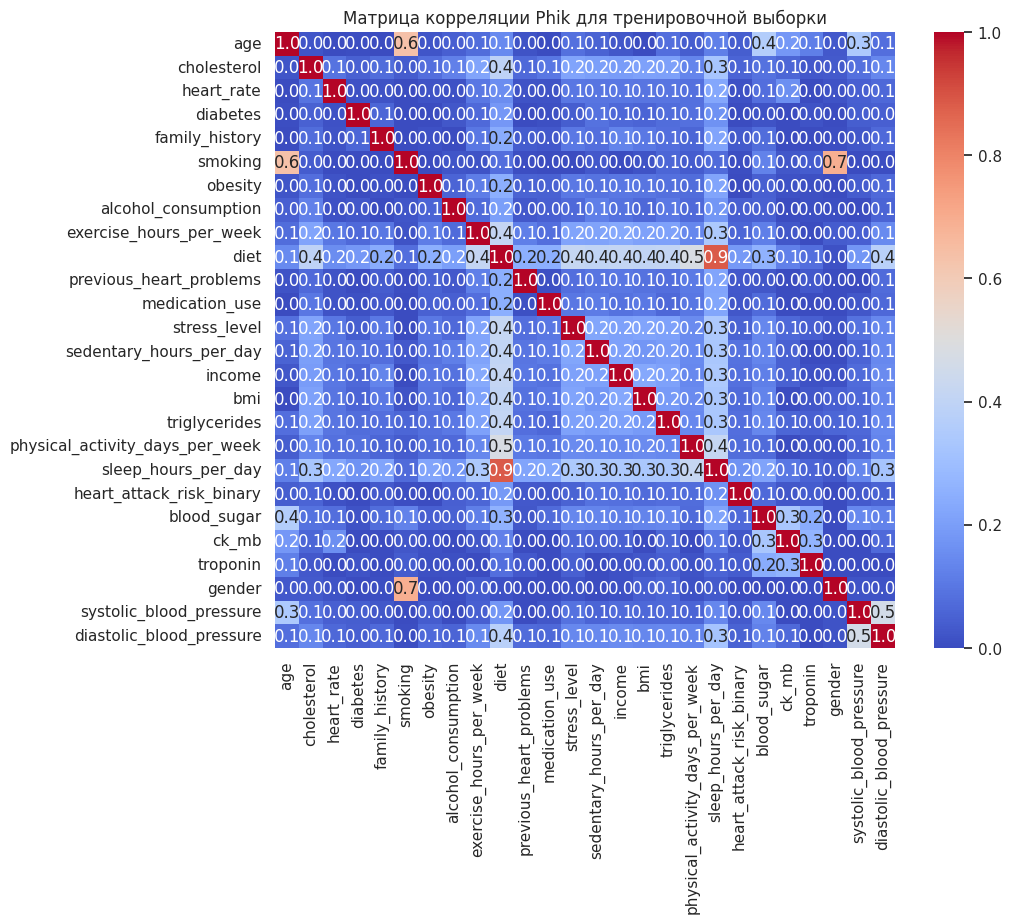

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(train_corr_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Матрица корреляции Phik для тренировочной выборки")
plt.show()

In [36]:
def corr_levels_table(corr_matrix, threshold=0.0):
    
    levels = [
        (0.9, "Весьма высокая"),
        (0.7, "Высокая"),
        (0.5, "Заметная"),
        (0.3, "Умеренная"),
        (0.1, "Слабая")
    ]
    
    rows = []
    for i, row in enumerate(corr_matrix.columns):
        for j, col in enumerate(corr_matrix.columns):
            if i < j:
                corr_value = corr_matrix.loc[row, col]
                abs_val = abs(corr_value)
                if abs_val > threshold:
                    for bound, label in levels:
                        if abs_val > bound:
                            rows.append({
                                "Признак 1": row,
                                "Признак 2": col,
                                "Уровень": label,
                                "Корреляция": round(corr_value, 3)
                            })
                            break
    df_result = pd.DataFrame(rows).sort_values(by="Корреляция", key=lambda x: abs(x), ascending=False)
    return df_result

In [37]:
corr_df = corr_levels_table(train_corr_matrix)
display(corr_df)

,Признак 1,Признак 2,Уровень,Корреляция
59,diet,sleep_hours_per_day,Высокая,0.887
30,smoking,gender,Заметная,0.693
0,age,smoking,Заметная,0.634
58,diet,physical_activity_days_per_week,Умеренная,0.479
114,systolic_blood_pressure,diastolic_blood_pressure,Умеренная,0.458
...,...,...,...,...
71,medication_use,physical_activity_days_per_week,Слабая,0.101
68,medication_use,stress_level,Слабая,0.101
65,previous_heart_problems,income,Слабая,0.101
23,family_history,exercise_hours_per_week,Слабая,0.101


In [38]:
df = heart_test.copy()
df = df.drop(columns=[c for c in ['id'] if c in df.columns])

num_features = [c for c in df.columns if is_numeric_dtype(df[c])]

test_corr_matrix = df.phik_matrix(interval_cols=num_features)

test_corr_matrix

,age,cholesterol,heart_rate,diabetes,family_history,smoking,obesity,alcohol_consumption,exercise_hours_per_week,diet,...,bmi,triglycerides,physical_activity_days_per_week,sleep_hours_per_day,blood_sugar,ck_mb,troponin,gender,systolic_blood_pressure,diastolic_blood_pressure
age,1.000000,0.194304,0.047017,0.000000,0.000000,0.622543,0.057216,0.000000,0.161621,0.134034,...,0.063944,0.000000,0.000000,0.053567,0.353476,0.083755,0.082129,0.000000,0.000000,0.000000
cholesterol,0.194304,1.000000,0.000000,0.047692,0.096264,0.096574,0.109935,0.092774,0.252520,0.429993,...,0.246128,0.242878,0.183015,0.350645,0.132238,0.000000,0.000000,0.000000,0.000000,0.000000
heart_rate,0.047017,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.252781,...,0.000000,0.000000,0.000000,0.207201,0.000000,0.000000,0.386842,0.000000,0.000000,0.000000
diabetes,0.000000,0.047692,0.000000,1.000000,0.000000,0.000000,0.000000,0.040902,0.086292,0.192280,...,0.127977,0.000000,0.000000,0.160508,0.000000,0.088141,0.000000,0.000000,0.049063,0.045659
family_history,0.000000,0.096264,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.007989,0.255766,...,0.109860,0.141258,0.126275,0.219650,0.092102,0.044399,0.000000,0.000000,0.000000,0.000000
smoking,0.622543,0.096574,0.000000,0.000000,0.000000,1.000000,0.085101,0.000000,0.094110,0.086912,...,0.000000,0.052842,0.050597,0.000000,0.115181,0.000000,0.000000,0.000000,0.000000,0.101896
obesity,0.057216,0.109935,0.000000,0.000000,0.000000,0.085101,1.000000,0.025472,0.000000,0.244491,...,0.129714,0.090027,0.125474,0.220163,0.114008,0.000000,0.000000,0.006188,0.031822,0.103267
alcohol_consumption,0.000000,0.092774,0.000000,0.040902,0.000000,0.000000,0.025472,1.000000,0.000000,0.210318,...,0.109335,0.150861,0.078444,0.207615,0.104911,0.065863,0.000000,0.059343,0.149234,0.000000
exercise_hours_per_week,0.161621,0.252520,0.000000,0.086292,0.007989,0.094110,0.000000,0.000000,1.000000,0.429541,...,0.185839,0.283987,0.124545,0.343084,0.195689,0.000000,0.000000,0.000000,0.000000,0.092992
diet,0.134034,0.429993,0.252781,0.192280,0.255766,0.086912,0.244491,0.210318,0.429541,1.000000,...,0.409553,0.460555,0.461420,0.886684,0.295048,0.017822,0.073737,0.000000,0.239504,0.241330


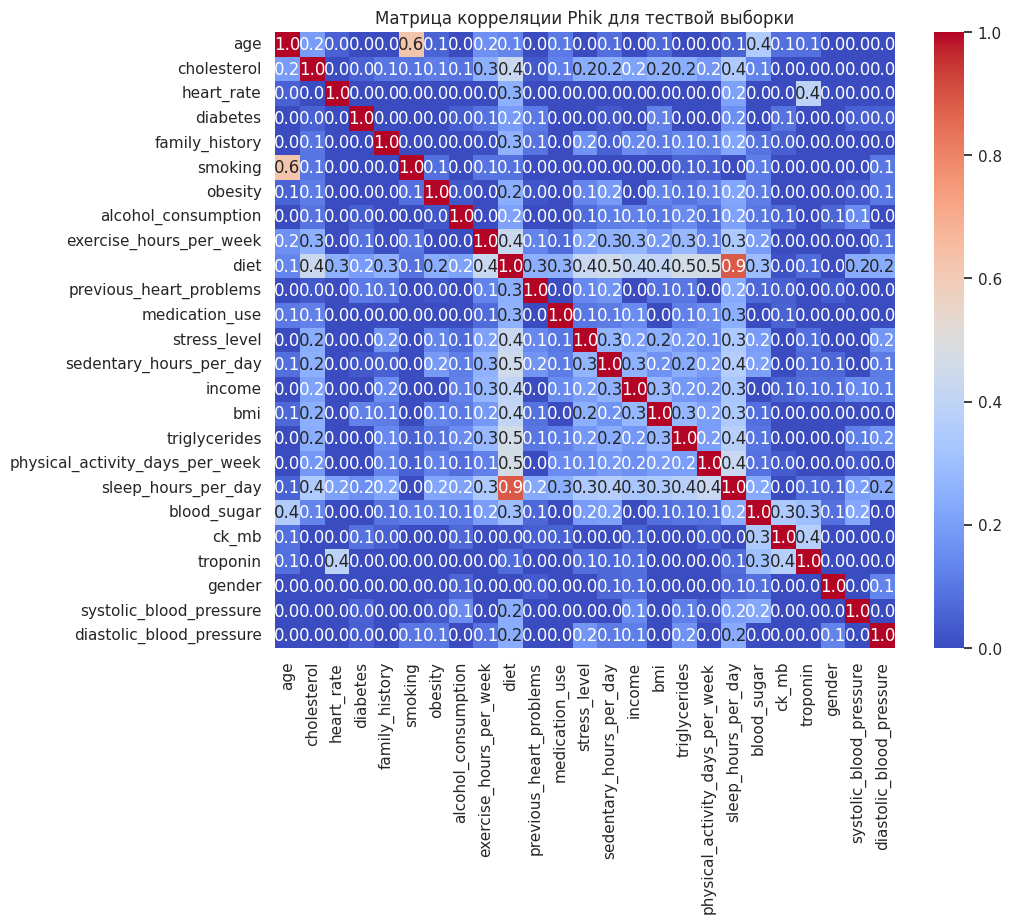

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(test_corr_matrix, annot=True, cmap='coolwarm', fmt=".1f")
plt.title("Матрица корреляции Phik для тествой выборки")
plt.show()

In [40]:
corr_df = corr_levels_table(test_corr_matrix, threshold = 0.15)
display(corr_df)

,Признак 1,Признак 2,Уровень,Корреляция
44,diet,sleep_hours_per_day,Высокая,0.887
1,age,smoking,Заметная,0.623
43,diet,physical_activity_days_per_week,Умеренная,0.461
42,diet,triglycerides,Умеренная,0.461
39,diet,sedentary_hours_per_day,Умеренная,0.451
...,...,...,...,...
2,age,exercise_hours_per_week,Слабая,0.162
66,income,physical_activity_days_per_week,Слабая,0.162
17,diabetes,sleep_hours_per_day,Слабая,0.161
26,alcohol_consumption,triglycerides,Слабая,0.151


**Вывод**

Анализ матриц корреляции для тренировочной и тестовой выборок показал их согласованность.
Существенных зависимостей между входными признаками и целевой переменной не выявлено.
Корреляция между входными признаками в целом низкая.

## Промежуточный вывод

- **Распределение данных** в целом равномерное и сбалансированное.  
- При анализе распределений признаков с разбивкой по целевому признаку статистически значимых различий не выявлено.  
- **Корреляция между признаками** — низкая.

### Количественные признаки с равномерным распределением и без выбросов:
`Stress Level`, `Physical Activity Days Per Week`, `Sleep Hours Per Day`, `Age`, `Cholesterol`, `Heart rate`,  
`Exercise Hours Per Week`, `Sedentary Hours Per Day`, `Income`, `BMI`, `Triglycerides`,  
`Systolic blood pressure`, `Diastolic blood pressure`.

### Количественные признаки с выраженной модой и большим числом выбросов:
`Blood sugar`, `CK-MB`, `Troponin`.

### Медицинская интерпретация
- **Blood sugar**:  
  Норма — 3.3–5.5 ммоль/л. Опасные значения — ниже 1.65 ммоль/л и выше 33 ммоль/л.  
  Повышенные значения часто наблюдаются после инфаркта миокарда.

- **CK-MB**:  
  Фермент — специфичный и чувствительный маркер повреждения миокарда.

- **Troponin**:  
  Биомаркер повреждения сердечной мышцы, особенно при инфаркте миокарда.  
  В норме значения близки к нулю, повышение говорит о повреждении миокарда.

> **Важно:** `CK-MB` и `Troponin` являются не предсказателями инфаркта, а следствием его наступления. Эти признаки содержат косвенную утечку целевого признака, поэтому **они будут исключены из обучения моделей**.


Так как признаки имеют одинаково низкую корреляцию с целевым признаком, **отбор признаков на данном этапе не проводится**.


## 5. Обучение моделей

In [41]:
# Укажем столбцы, которые не будут учавствовать в обучении моделей
drop_columns = ['id',
                'ck_mb', 
                'troponin',
                'heart_attack_risk_binary']


# Категориальные признаки номинальные:
ohe_columns = ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'diet', 
               'previous_heart_problems', 'medication_use', 'gender']

# Количественные признаки:
num_columns = ['age','cholesterol', 'heart_rate', 'exercise_hours_per_week', 'stress_level', 'sleep_hours_per_day',
               'income', 'bmi', 'triglycerides', 'physical_activity_days_per_week', 'blood_sugar',
               'systolic_blood_pressure', 'diastolic_blood_pressure']
# Целевой признак
target_feature = 'heart_attack_risk_binary'

In [42]:
df = heart_train.copy()

X = df.drop(columns=drop_columns, errors='ignore')
y = pd.to_numeric(df[target_feature], errors='coerce').fillna(0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

# Проверка уникальных значений в y
print("Уникальные значения целевой переменной:", y.unique())

Уникальные значения целевой переменной: [0 1]


In [43]:
# Импьютер для числовых
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Импьютер + OHE для категориальных
ohe_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Полный препроцессор с OHE (для LR/KNN/DT/RF/LGBM/XGB)
preproc_ohe = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('num', num_pipe, num_columns),
], remainder='drop')

# «Проходной» препроцессор (для CatBoost — он сам умеет категории)
preproc_passthrough = 'passthrough'

In [44]:
pipe = Pipeline([
    ('preprocessor', preproc_ohe),   # по умолчанию OHE
    ('model', LogisticRegression())
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_grid = [
    # Logistic Regression
    {
        'preprocessor': [preproc_ohe,],
        'model': [LogisticRegression(solver='liblinear', random_state=RANDOM_STATE)],
        'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'model__penalty': ['l1', 'l2'],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    # KNN
    {
        'preprocessor': [preproc_ohe,],
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': [3,4,5,6],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()]
    },
    # Decision Tree
    {
        'preprocessor': [preproc_ohe,],
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': list(range(3, 10))
    },
    # RandomForest
    {
        'preprocessor': [preproc_ohe,],
        'model': [RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100)],
        'model__max_depth': list(range(4, 12))
    },
    # LightGBM
    {
        'preprocessor': [preproc_ohe,],
        'model': [LGBMClassifier(random_state=RANDOM_STATE, n_estimators=400)],
        'model__learning_rate': [0.03, 0.1],
        'model__max_depth': [-1, 6, 8],
        'model__num_leaves': [31, 63],
        'model__verbosity': [-1],
    },
    # XGBoost
    {
        'preprocessor': [preproc_ohe,],
        'model': [XGBClassifier(
            random_state=RANDOM_STATE, n_estimators=400, eval_metric='logloss',
            tree_method='hist', n_jobs=-1
        )],
        'model__learning_rate': [0.03, 0.1],
        'model__max_depth': [4, 6, 8],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0],
        'model__verbosity': [-1]
    },
]

In [45]:
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=1,
    
)
grid.fit(X_train, y_train)

print("\nЛучшая модель:", type(grid.best_estimator_.named_steps['model']).__name__)
print("\nПараметры модели:\n", grid.best_estimator_.named_steps['model'])
print("\nЛучший ROC-AUC (CV):", round(grid.best_score_, 5))


Лучшая модель: LGBMClassifier

Параметры модели:
 LGBMClassifier(max_depth=8, n_estimators=400, num_leaves=63, random_state=42,
               verbosity=-1)

Лучший ROC-AUC (CV): 0.58442



AP (Average Precision): 0.45831
Оптимальный порог по PR (по F1): 0.08950

Тест, порог 0.50
ROC-AUC: 0.58954
Accuracy: 0.634
Precision: 0.451
Recall: 0.252
F1: 0.323

Тест, оптимальный порог 0.089 (по F1)
ROC-AUC: 0.58954
Accuracy: 0.456
Precision: 0.38
Recall: 0.9
F1: 0.535



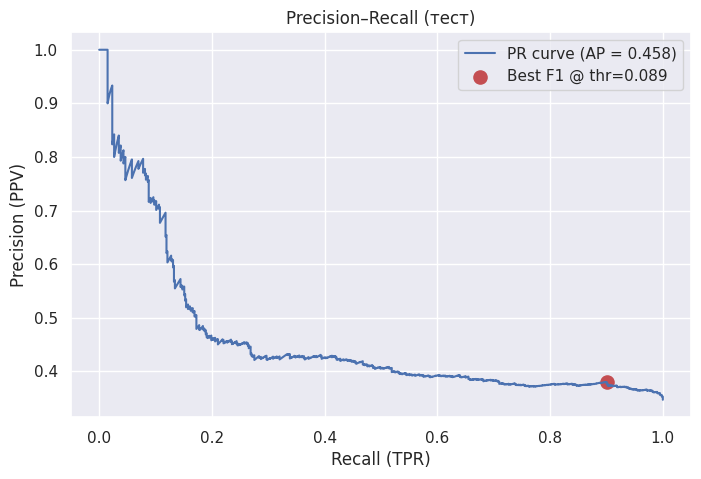

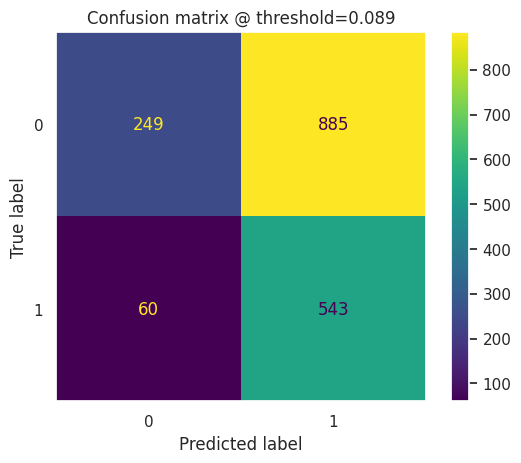

In [46]:
best_model = grid.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]

# PR-кривая и AP
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

# Оптимальный порог по F1 на PR-кривой
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[best_idx]

print(f"\nAP (Average Precision): {ap:.5f}")
print(f"Оптимальный порог по PR (по F1): {optimal_threshold:.5f}\n")

def print_metrics(y_true, y_prob, thr=0.5, title="Метрики"):
    y_hat = (y_prob >= thr).astype(int)
    print(title)
    print("ROC-AUC:", round(roc_auc_score(y_true, y_prob), 5))
    print("Accuracy:", round(accuracy_score(y_true, y_hat), 3))
    print("Precision:", round(precision_score(y_true, y_hat), 3))
    print("Recall:", round(recall_score(y_true, y_hat), 3))
    print("F1:", round(f1_score(y_true, y_hat), 3))
    print()

# Метрики для порогов 0.50 и оптимального
print_metrics(y_test, y_proba, 0.5,  "Тест, порог 0.50")
print_metrics(y_test, y_proba, optimal_threshold,
              f"Тест, оптимальный порог {optimal_threshold:.3f} (по F1)")

# --- График PR + отметка оптимального порога ---
plt.figure(figsize=(8, 5))
plt.plot(recall, precision, label=f'PR curve (AP = {ap:.3f})')
plt.scatter(recall[best_idx], precision[best_idx], s=90, c='r',
            label=f'Best F1 @ thr={optimal_threshold:.3f}')
plt.xlabel('Recall (TPR)')
plt.ylabel('Precision (PPV)')
plt.title('Precision–Recall (тест)')
plt.legend()
plt.grid(True)
plt.show()

# (опционально) Confusion matrix при оптимальном пороге:
ConfusionMatrixDisplay.from_predictions(y_test, (y_proba >= optimal_threshold).astype(int))
plt.title(f"Confusion matrix @ threshold={optimal_threshold:.3f}")
plt.grid(False)
plt.show()


In [47]:
dummy = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
y_dummy_proba = dummy.predict_proba(X_test)[:, 1]
print_metrics(y_test, y_dummy_proba, optimal_threshold, "DummyClassifier (stratified)")

DummyClassifier (stratified)
ROC-AUC: 0.48527
Accuracy: 0.534
Precision: 0.328
Recall: 0.325
F1: 0.326



In [48]:
joblib.dump(best_model, "best_model.pkl")
joblib.dump(list(X_train.columns), "best_model_feature_list.pkl")
joblib.dump(optimal_threshold, "best_model_threshold.pkl")

loaded = joblib.load("best_model.pkl")
y_loaded_proba = loaded.predict_proba(X_test)[:, 1]
print_metrics(y_test, y_loaded_proba, optimal_threshold, "Загруженная модель")

Загруженная модель
ROC-AUC: 0.58954
Accuracy: 0.456
Precision: 0.38
Recall: 0.9
F1: 0.535



PermutationExplainer explainer: 1738it [10:27,  2.73it/s]                                                                                                                                              


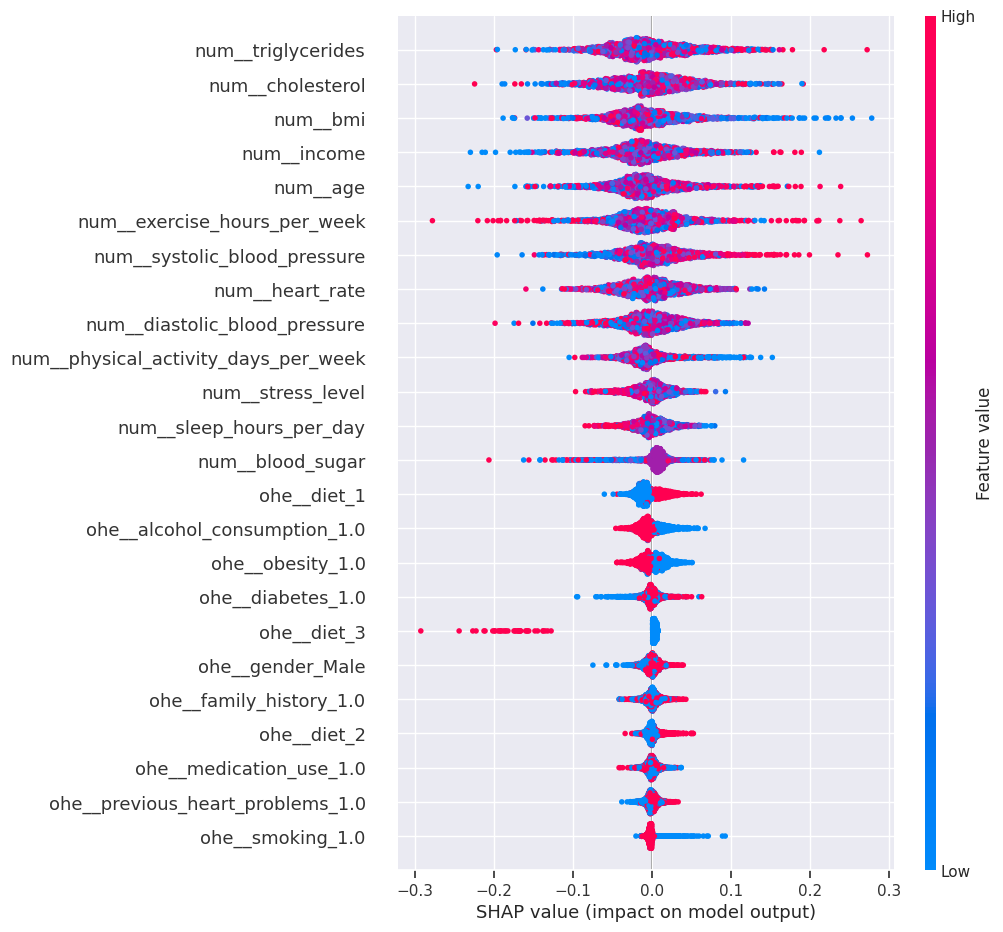

In [49]:
# Фичи после препроцессора
try:
    feat_names = best_model['preprocessor'].get_feature_names_out()
except Exception:
    feat_names = X_train.columns

# Формируем матрицы для объяснения
if hasattr(best_model['preprocessor'], "transform"):
    X_train_enc = best_model['preprocessor'].transform(X_train)
    X_test_enc  = best_model['preprocessor'].transform(X_test)
else:
    # passthrough (CatBoost)
    X_train_enc = X_train
    X_test_enc  = X_test

# Универсальный пермут. SHAP (работает для любого clf с predict_proba)
explainer = shap.PermutationExplainer(best_model['model'].predict_proba, X_train_enc)
shap_values = explainer(X_test_enc)

# Для бинарной берем класс 1
sv = shap.Explanation(
    values=shap_values.values[..., 1],
    base_values=shap_values.base_values[..., 1],
    data=X_test_enc,
    feature_names=feat_names
)
shap.plots.beeswarm(sv, max_display=25)

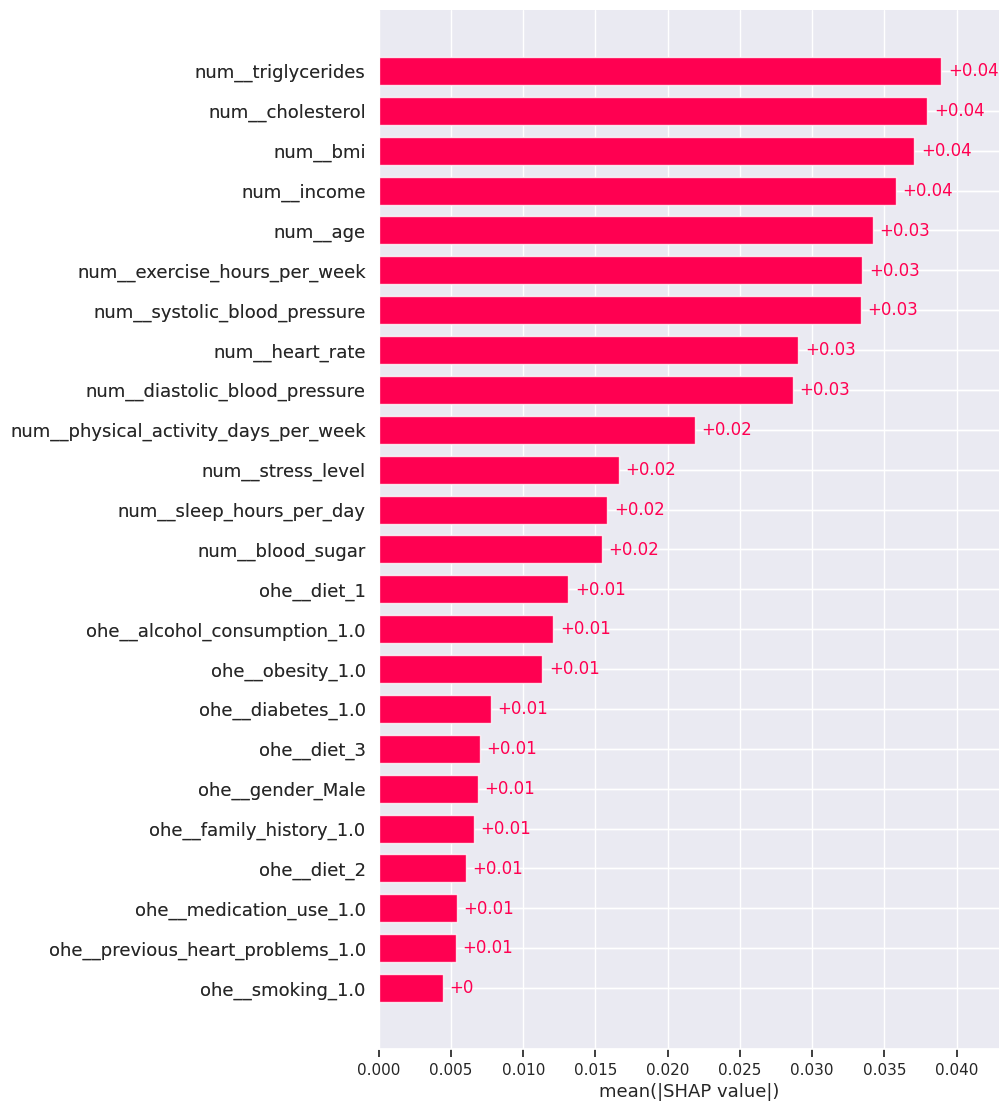

In [50]:
top_n = 30
shap.plots.bar(sv, max_display=top_n)

## Получение предсказаний

In [51]:
X_test_final = heart_test.drop(columns=drop_columns, errors='ignore')

y_proba_final = best_model.predict_proba(X_test_final)[:, 1]

test_ids_final = heart_test['id']

# 4) Сохранение с порогом 0.5
sub_050 = pd.DataFrame({
    'id': test_ids_final,
    'prediction': (y_proba_final >= 0.5).astype(int)
})
sub_050.to_csv('pred_050_FINAL.csv', index=False)
print("Сохранено FINAL: pred_050_FINAL.csv")

# 5) Сохранение с оптимальным порогом
sub_opt = pd.DataFrame({
    'id': test_ids_final,
    'prediction': (y_proba_final >= optimal_threshold).astype(int)
})
sub_opt.to_csv(f'pred_OPT_{optimal_threshold:.3f}_FINAL.csv', index=False)
print(f"Сохранено FINAL: pred_OPT_{optimal_threshold:.3f}_FINAL.csv")

# 6) Показать первые 10 результатов
preview = pd.DataFrame({
    'id': test_ids_final,
    'proba': y_proba_final,
    'pred_0.50': (y_proba_final >= 0.5).astype(int),
    f'pred_{optimal_threshold:.3f}': (y_proba_final >= optimal_threshold).astype(int)
})
print("\nПервые 10 строк результата по heart_test:")
print(preview.head(10))

Сохранено FINAL: pred_050_FINAL.csv
Сохранено FINAL: pred_OPT_0.089_FINAL.csv

Первые 10 строк результата по heart_test:
     id     proba  pred_0.50  pred_0.089
0  7746  0.277612          0           1
1  4202  0.283321          0           1
2  6632  0.102066          0           1
3  4639  0.178962          0           1
4  4825  0.559948          1           1
5  1076  0.607401          1           1
6  5020  0.605284          1           1
7  4267  0.047500          0           0
8  4003  0.677169          1           1
9  2519  0.472361          0           1


## Общий вывод

**Целью проекта** было создание модели машинного обучения для прогнозирования риска сердечного приступа на основе медицинских данных пациентов, а также подготовка библиотеки и API-интерфейса для прикладного использования модели.

### Задачи, которые были решены:
- Загрузка и предобработка данных, включая удаление пропусков, приведение типов и переименование столбцов;
- Проведение исследовательского анализа данных и выявление особенностей распределения признаков;
- Анализ корреляций и проверка на мультиколлинеарность;
- Исключение признаков, содержащих утечку целевого признака (кфк-мв, тропонин);;
- Обучение нескольких моделей и выбор наилучшей по метрике ROC-AUC;
- Реализация обработки строк с пропущенными значениями через обёртку к модели;
- Оценка важности признаков с использованием SHAP-метода.

### Ключевые выводы:
Матрица ошибок позволяет различать четыре вида предсказаний модели: **True Positive (TP)**, **True Negative (TN)**, **False Positive (FP)** и **False Negative (FN)**.  
Прогнозы **FP** называют ошибками первого рода, а **FN** — ошибками второго рода.

По текущей матрице ошибок:
- **FP (ошибки 1-го рода)** — 875 случаев: модель ошибочно прогнозирует наличие риска, которого нет;
- **FN (ошибки 2-го рода)** — 60 случаев: модель не выявляет риск, который на самом деле есть;
- **TP** — 543 случаев: модель правильно предсказывает наличие риска;
- **TN** — 249 случаев: модель правильно предсказывает отсутствие риска.

Модель совершает ошибки FP гораздо чаще, чем FN, что говорит о том, что она **эффективнее избегает ошибок второго типа**.  
Это значит, что модель склонна "перестраховываться", чаще сигнализируя о риске, даже если его нет.

По метрикам это приведёт к тому, что **precision будет ниже, чем recall**.  
**Accuracy** модели составляет примерно 45,00%, то есть модель верно определяет класс heart_attack_risk_binary чуть меньше, чем в половине случаев. Accuracy показывает общий процент правильных предсказаний, но не раскрывает, какой класс предсказывается лучше.

Важным в медицинской задаче является минимизация FN, так как лучше предупредить пациента о возможной угрозе, чем упустить её. Такой подход позволяет сфокусировать внимание пациента на дополнительных обследованиях и профилактике.

### Предложения:
- Сфокусироваться на уменьшении числа ложноположительных срабатываний (FP), чтобы снизить избыточные предупреждения;
- Расширить и разнообразить обучающую выборку;
- Пересмотреть состав признаков и добавить дополнительные клинически значимые параметры;
- Рассмотреть изменение порога классификации для оптимального баланса между precision и recall.
